In [21]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from deap import base, creator, tools, algorithms
from optimize_portfolio import optimize_portfolio


In [22]:
"""
Data Setup
"""

# Load the dataset
asset_index = pd.read_excel("data/asset_index.xlsx")
trade_dt = pd.read_excel("data/ashare_trading_calender.xlsx")
asset_index = asset_index[asset_index['TRADE_DT'].isin(trade_dt['TRADE_DT'])]

unique_assets = asset_index['INDEX_CODE'].unique() # index_code list

In [23]:
"""
Clustering (Optional)
"""


'\nClustering (Optional)\n'

In [24]:
"""
GA Initialization
"""

# Objective Setup
creator.create("FitnessMulti", base.Fitness, weights=(1.0, 1.0, -1.0)) # MAX: return, sharpe; MIN: volatility
creator.create("Individual", list, fitness=creator.FitnessMulti)

# Individual Initialization (Clustering?)
def create_individual():
    individual = [random.randint(0, 1) for _ in range(len(unique_assets))]
    if sum(individual) == 0:  # If all zeros, randomly set one to 1
        individual[random.randint(0, len(unique_assets) - 1)] = 1
    return individual

# GA Initialization
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
# toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(unique_assets))
toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [25]:
"""
Fitness Function with Regularization (Optional)
"""

# Fitness Function
def evaluate(individual):
    # Select assets based on the individual's binary vector
    selected_assets = [asset for asset, include in zip(unique_assets, individual) if include]

    # if selected assets are empty (might be caused by mutation, crossover), just set output to extreme situation?

    # Model output (new weights)
    new_weights, evaluation = optimize_portfolio('MVO', selected_assets, asset_index)

    # Expected Return, Sharpe Ratio, Volatility (Add regularization parameters? a+b+c=1?)
    expected_return, sharpe_ratio, volatility = evaluation

    return expected_return, sharpe_ratio, volatility

In [26]:
"""
Genetic Algorithm Setup
"""

# NSGA-II
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selNSGA2)

In [27]:
""""
Run Genetic Algorithm
"""

# Running the GA
def run_ga(pop_size, num_generations):
    pop = toolbox.population(n=pop_size)
    hof = tools.ParetoFront()
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean, axis=0)
    stats.register("std", np.std, axis=0)
    stats.register("min", np.min, axis=0)
    stats.register("max", np.max, axis=0)

    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.2, ngen=num_generations, stats=stats, halloffame=hof, verbose=True)

    return pop, hof, stats, logbook

# Example run
population, pareto_front, stats, logbook = run_ga(5, 20)  # 5 individuals, 20 generations

['HSI.HI', 'DOLLAR', 'h00300.CSI']
['DOLLAR', 'h00300.CSI', 'CBA02001.CS']
['DOLLAR', 'GC.CMX']
['HSI.HI', 'DOLLAR', 'h00300.CSI']
['HSI.HI', 'CBA02001.CS']
gen	nevals	avg                                           	std                                           	min                                           	max                                           
0  	5     	[1.35830416e-01 1.89204858e-04 6.00873082e+02]	[7.95257292e-02 1.37196557e-04 3.59784306e+02]	[2.03576663e-02 9.79258741e-06 3.65241832e+01]	[2.00000000e-01 3.01555466e-04 1.17420174e+03]
['HSI.HI', 'DOLLAR', 'h00300.CSI']
['HSI.HI', 'DOLLAR', 'h00300.CSI']
['DOLLAR', 'h00300.CSI']
['DOLLAR', 'GC.CMX', 'CBA02001.CS']
1  	4     	[1.38554873e-01 2.96491206e-04 5.98972522e+02]	[7.56626145e-02 1.62602866e-04 3.63233386e+02]	[3.39799500e-02 3.30389687e-05 2.55593102e+01]	[2.00000000e-01 5.46961161e-04 1.17420174e+03]
['HSI.HI', 'DOLLAR', 'h00300.CSI']
['HSI.HI', 'DOLLAR', 'h00300.CSI']
['DOLLAR', 'h00300.CSI']
['DOLLAR', 'GC.CMX']

ValueError: Invalid dimensions (0,).

In [ ]:
# Population
print("Population")
print(population)

In [ ]:
# Pareto Front
# Retrieve Weights
def get_weights(individual):
    selected_assets = [asset for asset, include in zip(unique_assets, individual) if include]
    new_weights, evaluation = optimize_portfolio('MVO', selected_assets, asset_index)
    return new_weights

# Retrieve and store weights
individual_weights = {str(ind): get_weights(ind) for ind in pareto_front}

print("Pareto Front")
for ind in pareto_front:
    print(f"Individual: {ind}, Weights: {individual_weights[str(ind)]}")

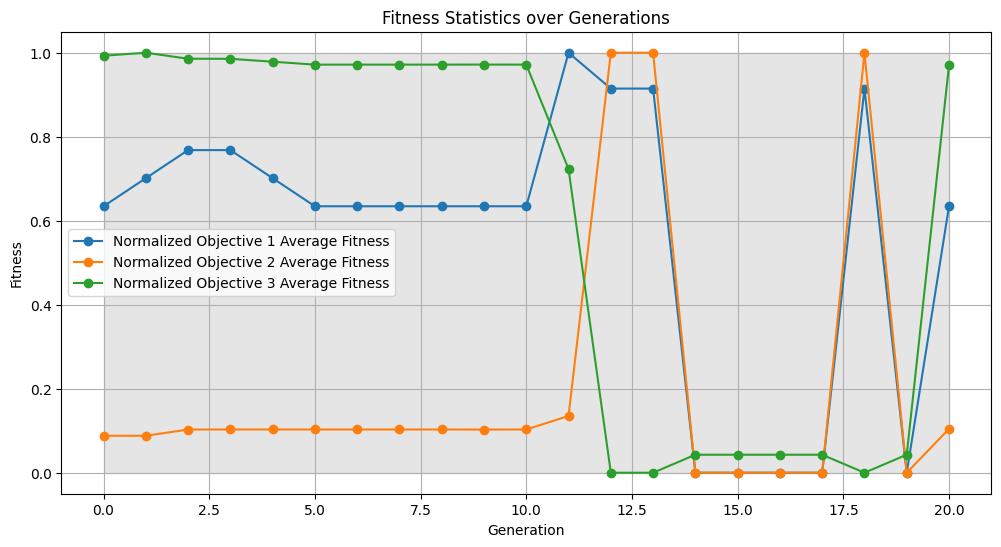

In [ ]:
# Extracting the statistics
# Extracting the statistics
gen = logbook.select("gen")
avg_fitness = logbook.select("avg")
std_fitness = logbook.select("std")
min_fitness = logbook.select("min")
max_fitness = logbook.select("max")

# Normalization function
def normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (data - min_val) / (max_val - min_val)

# Normalizing the average fitness for each objective
normalized_avg_fitness = [normalize([fit[i] for fit in avg_fitness]) for i in range(len(avg_fitness[0]))]

# Plotting for multiple objectives
plt.figure(figsize=(12, 6))

# Loop through each objective
for i, obj_avg in enumerate(normalized_avg_fitness):
    # Plot the normalized average fitness for this objective
    plt.plot(gen, obj_avg, label=f'Normalized Objective {i+1} Average Fitness', marker='o')

plt.fill_between(gen, 0, 1, alpha=0.2, color='grey')

plt.title('Fitness Statistics over Generations')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend()
plt.grid(True)
plt.show()
